# Practice Activity Recurrent Neural Networks

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from plotnine import ggplot, geom_point, geom_smooth, aes, stat_smooth, geom_line, xlim, ylim

2024-05-15 18:05:12.675470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

## Train/Test Split 1
In this train/test split we will be using an 80/20 split to run two neural networks, one SimpleRNN and one LSTM model, with three different lookback values.

### LSTM: 1 Day Lookback

In [51]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(275, 1) (68, 1)
(275, 1, 1) (68, 1, 1)


In [52]:
# LSTM Neural Network
model = Sequential()
model.add(LSTM(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


275/275 - 1s - 4ms/step - loss: 0.1034 - mean_squared_error: 0.1034
Epoch 2/100
275/275 - 0s - 724us/step - loss: 0.0463 - mean_squared_error: 0.0463
Epoch 3/100
275/275 - 0s - 706us/step - loss: 0.0292 - mean_squared_error: 0.0292
Epoch 4/100
275/275 - 0s - 728us/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 5/100
275/275 - 0s - 703us/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 6/100
275/275 - 0s - 757us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 7/100
275/275 - 0s - 768us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/100
275/275 - 0s - 737us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/100
275/275 - 0s - 700us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/100
275/275 - 0s - 714us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 11/100
275/275 - 0s - 686us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 12/100
275/275 - 0s - 744us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 13/100
275/275 - 0s -

In [53]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 39798.023226590674
Test RMSE: 13553.302017720227


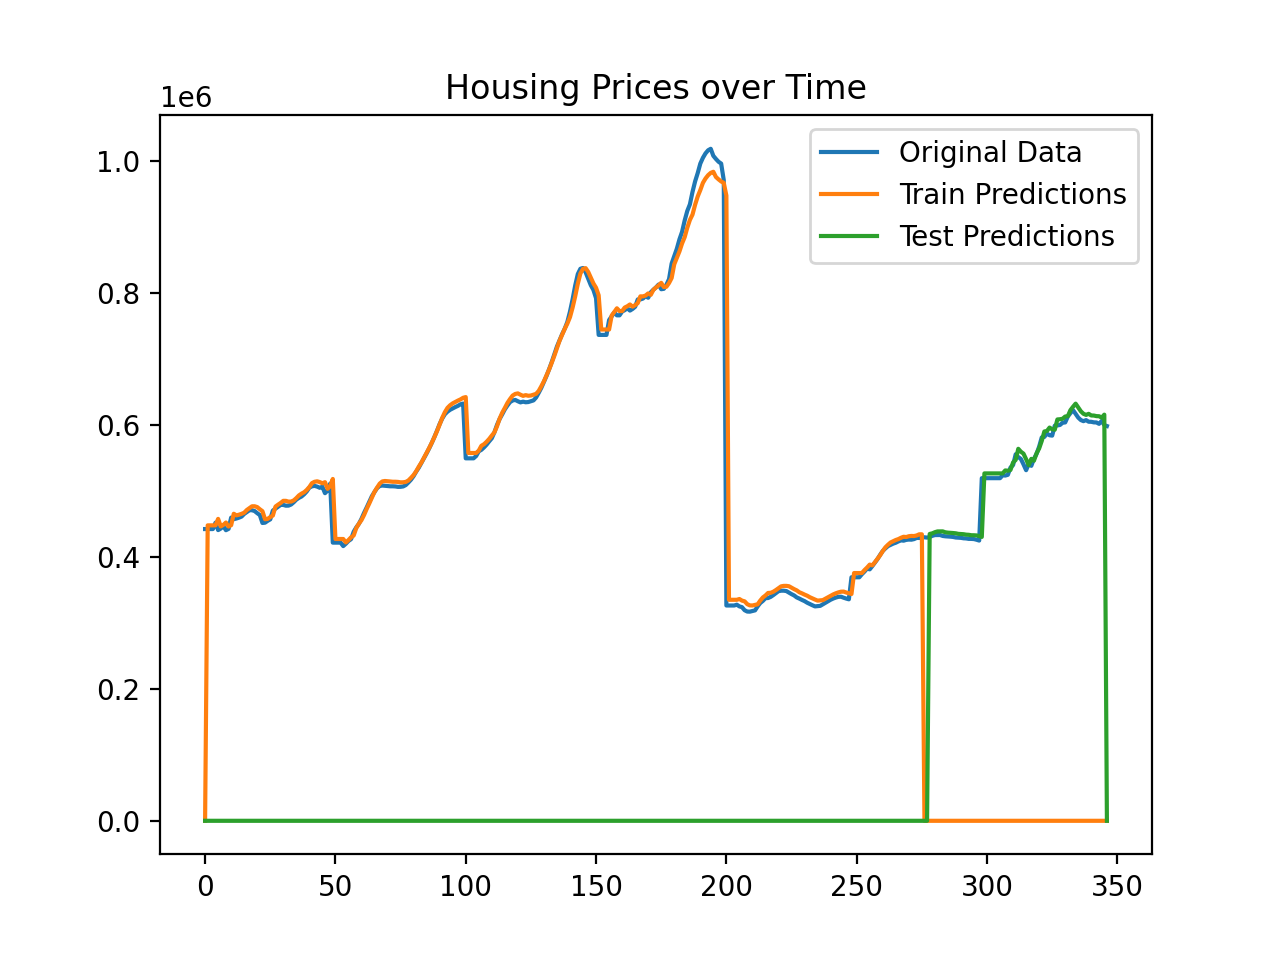

In [54]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### Simple RNN: 1 Day Lookback

In [58]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(275, 1) (68, 1)
(275, 1, 1) (68, 1, 1)


In [59]:
# Simple RNN Network
model = Sequential()
model.add(SimpleRNN(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


275/275 - 1s - 4ms/step - loss: 0.0808 - mean_squared_error: 0.0808
Epoch 2/100
275/275 - 0s - 660us/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 3/100
275/275 - 0s - 656us/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4/100
275/275 - 0s - 667us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 5/100
275/275 - 0s - 647us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 6/100
275/275 - 0s - 667us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 7/100
275/275 - 0s - 657us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/100
275/275 - 0s - 660us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 9/100
275/275 - 0s - 650us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/100
275/275 - 0s - 672us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 11/100
275/275 - 0s - 649us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 12/100
275/275 - 0s - 692us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 13/100
275/275 - 0s -

In [60]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 39626.04641671061
Test RMSE: 13454.982333328202


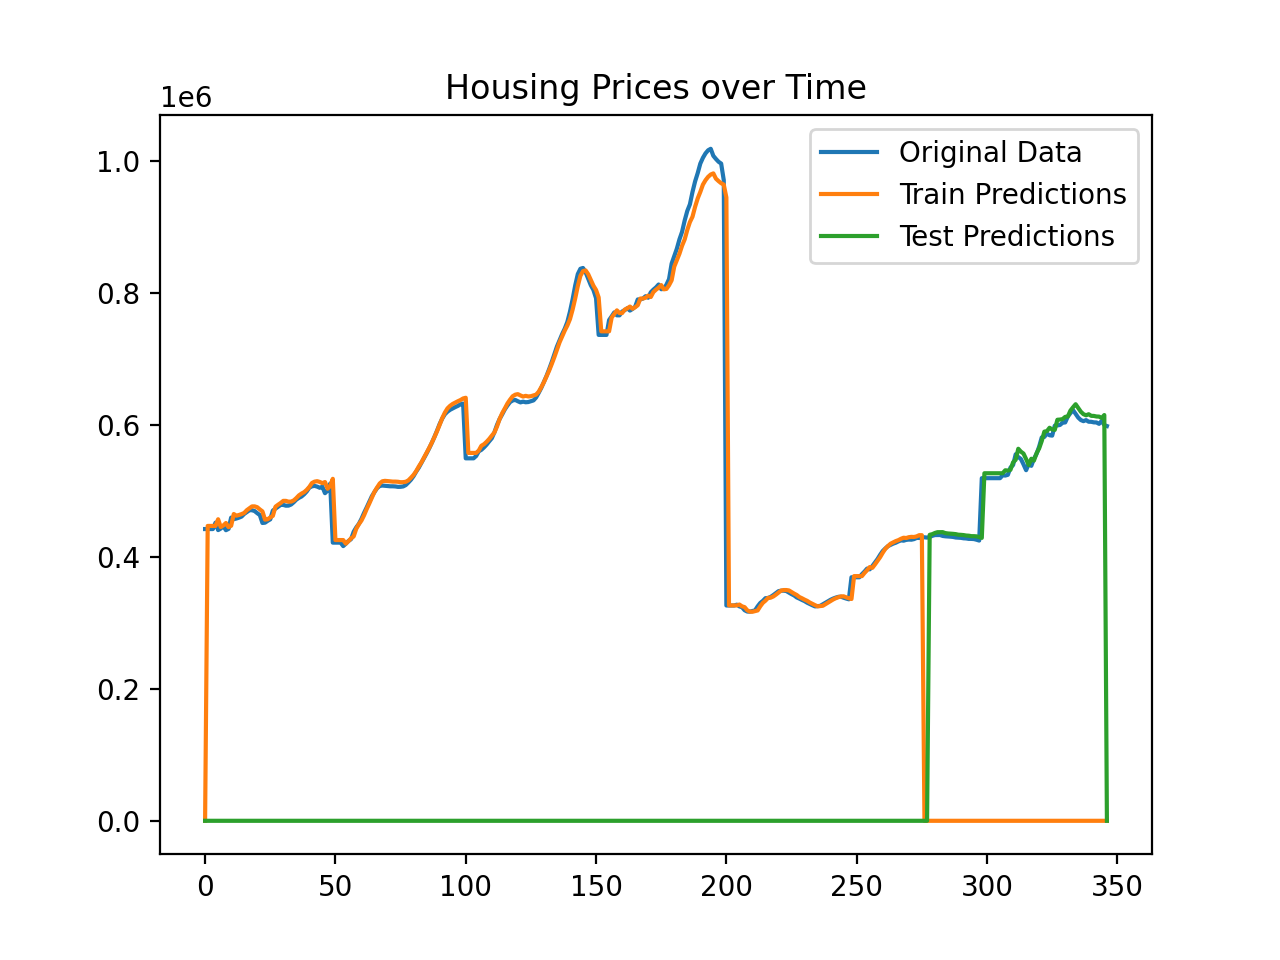

In [61]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### LSTM: 2 Day Lookback

In [65]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 2 days
look_back = 2
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(274, 2) (67, 2)
(274, 1, 2) (67, 1, 2)


In [66]:
# LSTM Neural Network
model = Sequential()
model.add(LSTM(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


274/274 - 1s - 4ms/step - loss: 0.0909 - mean_squared_error: 0.0909
Epoch 2/100
274/274 - 0s - 745us/step - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 3/100
274/274 - 0s - 712us/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 4/100
274/274 - 0s - 755us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 5/100
274/274 - 0s - 758us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 6/100
274/274 - 0s - 760us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 7/100
274/274 - 0s - 738us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 8/100
274/274 - 0s - 710us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 9/100
274/274 - 0s - 732us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/100
274/274 - 0s - 745us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/100
274/274 - 0s - 743us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 12/100
274/274 - 0s - 724us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 13/100
274/274 - 0s -

In [67]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 39976.881490795226
Test RMSE: 14895.777513474588


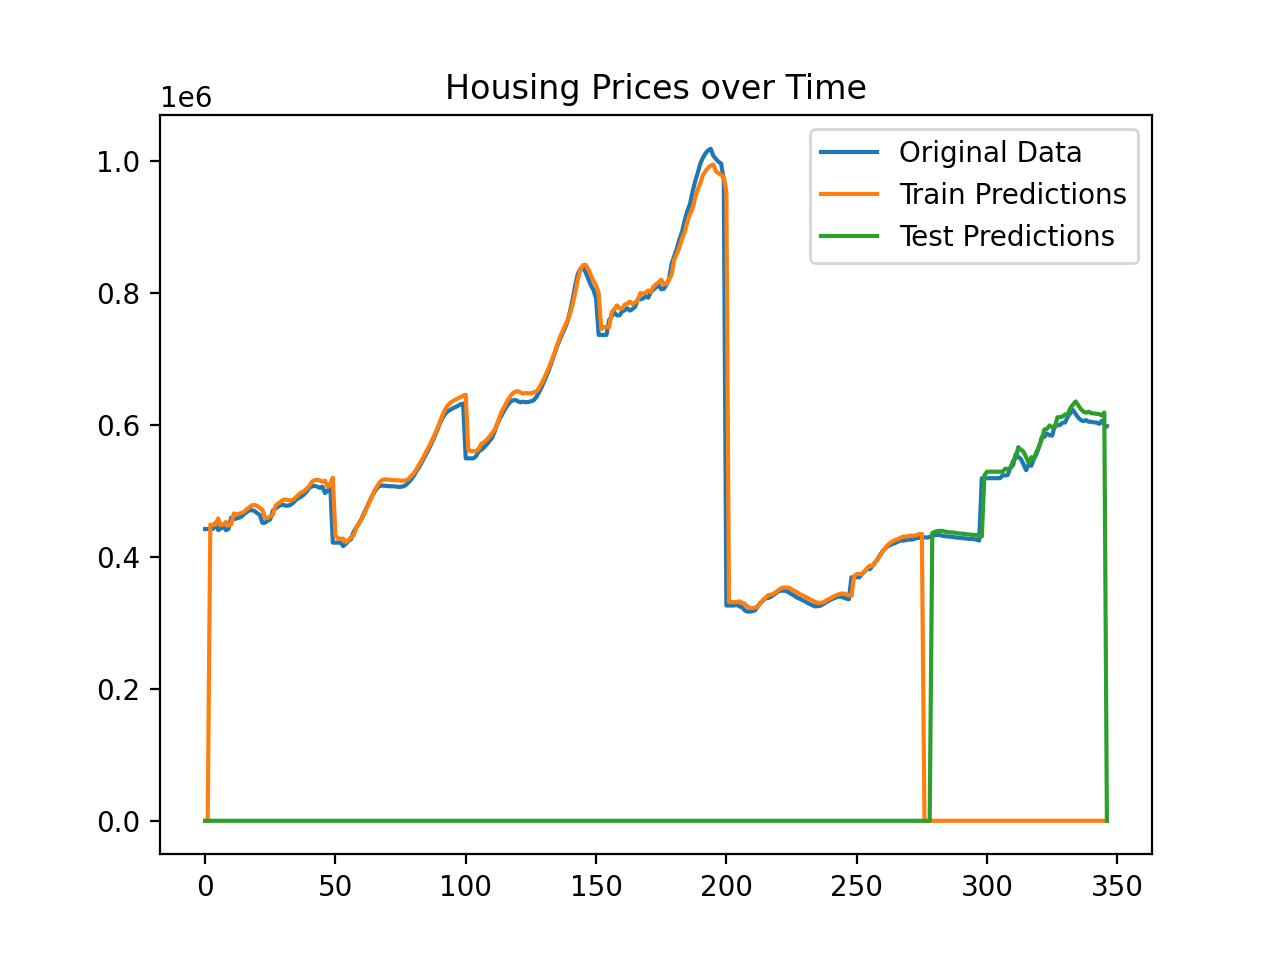

In [68]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### Simple RNN: 2 Day Lookback

In [69]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 2 days
look_back = 2
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(274, 2) (67, 2)
(274, 1, 2) (67, 1, 2)


In [70]:
# Simple RNN Network
model = Sequential()
model.add(SimpleRNN(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
274/274 - 1s - 4ms/step - loss: 0.0393 - mean_squared_error: 0.0393
Epoch 2/100
274/274 - 0s - 653us/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 3/100
274/274 - 0s - 702us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/100
274/274 - 0s - 662us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/100
274/274 - 0s - 686us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 6/100
274/274 - 0s - 694us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 7/100
274/274 - 0s - 665us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 8/100
274/274 - 0s - 686us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 9/100
274/274 - 0s - 719us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/100
274/274 - 0s - 664us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/100
274/274 - 0s - 639us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 12/100
274/274 - 0s - 695us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 13/100
27

In [71]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 40012.47766383234
Test RMSE: 16284.146573402384


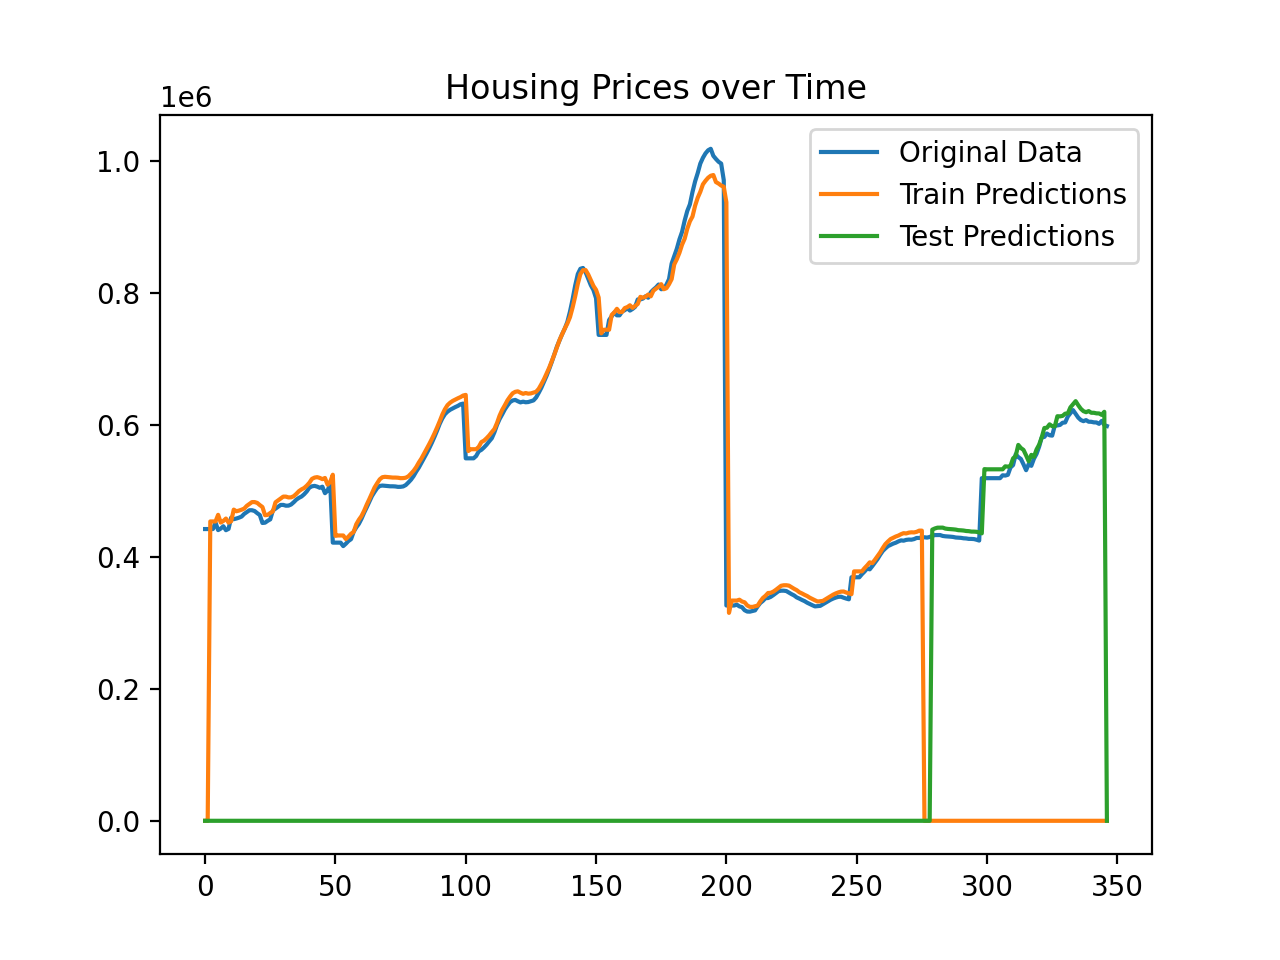

In [72]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### LSTM: 3 Day Lookback

In [74]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 3 days
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(273, 3) (66, 3)
(273, 1, 3) (66, 1, 3)


In [75]:
# LSTM Neural Network
model = Sequential()
model.add(LSTM(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
273/273 - 2s - 7ms/step - loss: 0.0457 - mean_squared_error: 0.0457
Epoch 2/100
273/273 - 0s - 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 3/100
273/273 - 0s - 1ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 4/100
273/273 - 0s - 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 5/100
273/273 - 0s - 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 6/100
273/273 - 0s - 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/100
273/273 - 0s - 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 8/100
273/273 - 0s - 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 9/100
273/273 - 0s - 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/100
273/273 - 0s - 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 11/100
273/273 - 0s - 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 12/100
273/273 - 0s - 1ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 13/100
273/273 - 0s - 1ms/step 

In [76]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 39456.405254407895
Test RMSE: 13294.854608134392


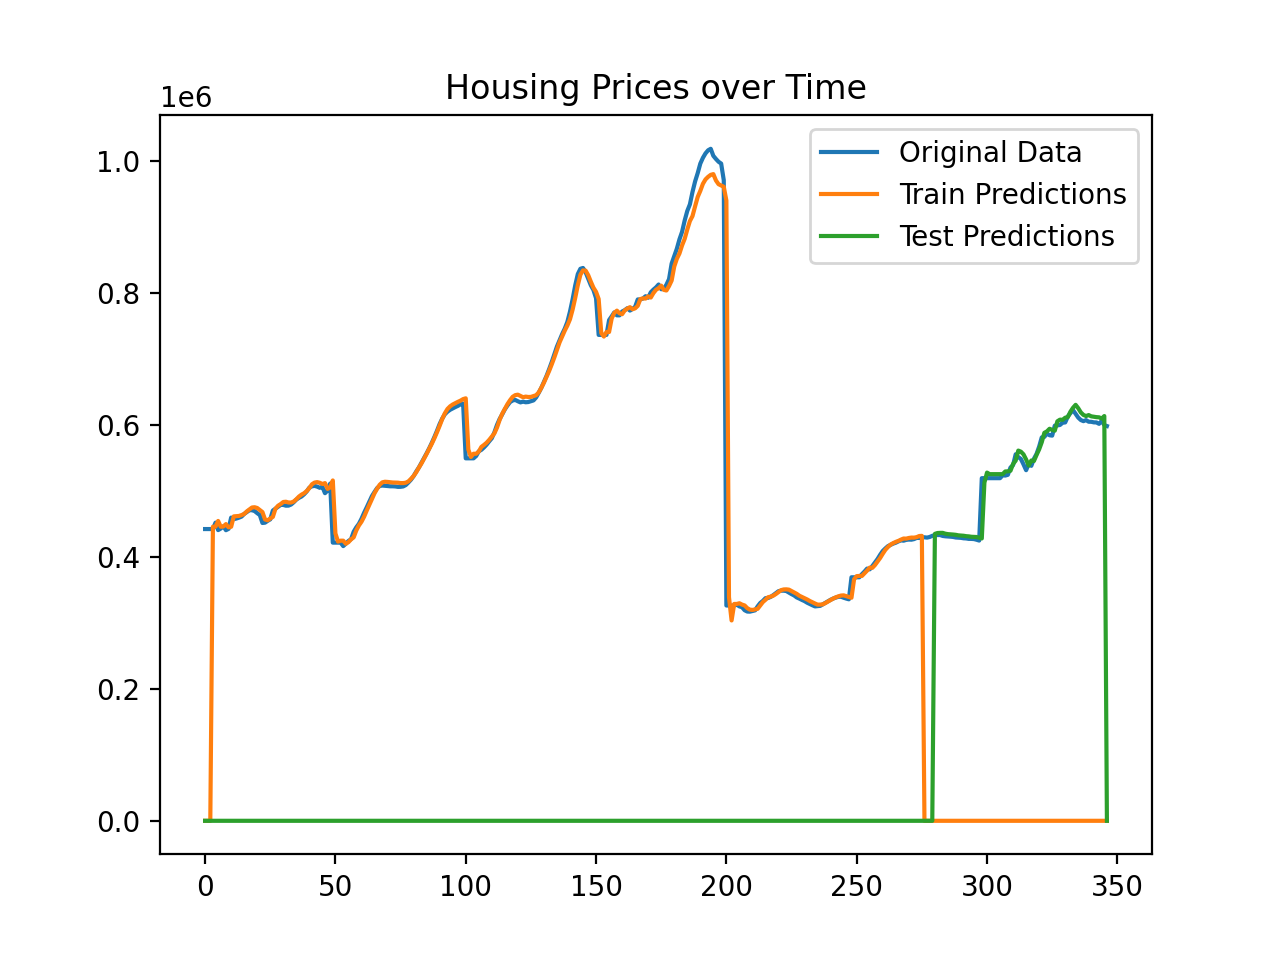

In [77]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### Simple RNN: 3 Day Lookback

In [78]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 3 days
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

277 70
(273, 3) (66, 3)
(273, 1, 3) (66, 1, 3)


In [79]:
# Simple RNN Network
model = Sequential()
model.add(SimpleRNN(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


273/273 - 2s - 6ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 2/100
273/273 - 0s - 1ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 3/100
273/273 - 0s - 1ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 4/100
273/273 - 0s - 1ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 5/100
273/273 - 0s - 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 6/100
273/273 - 0s - 1ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 7/100
273/273 - 0s - 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 8/100
273/273 - 0s - 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/100
273/273 - 0s - 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 10/100
273/273 - 0s - 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 11/100
273/273 - 0s - 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 12/100
273/273 - 0s - 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 13/100
273/273 - 0s - 1ms/step - loss: 0.00

In [80]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 39238.81114305084
Test RMSE: 14357.780147648673


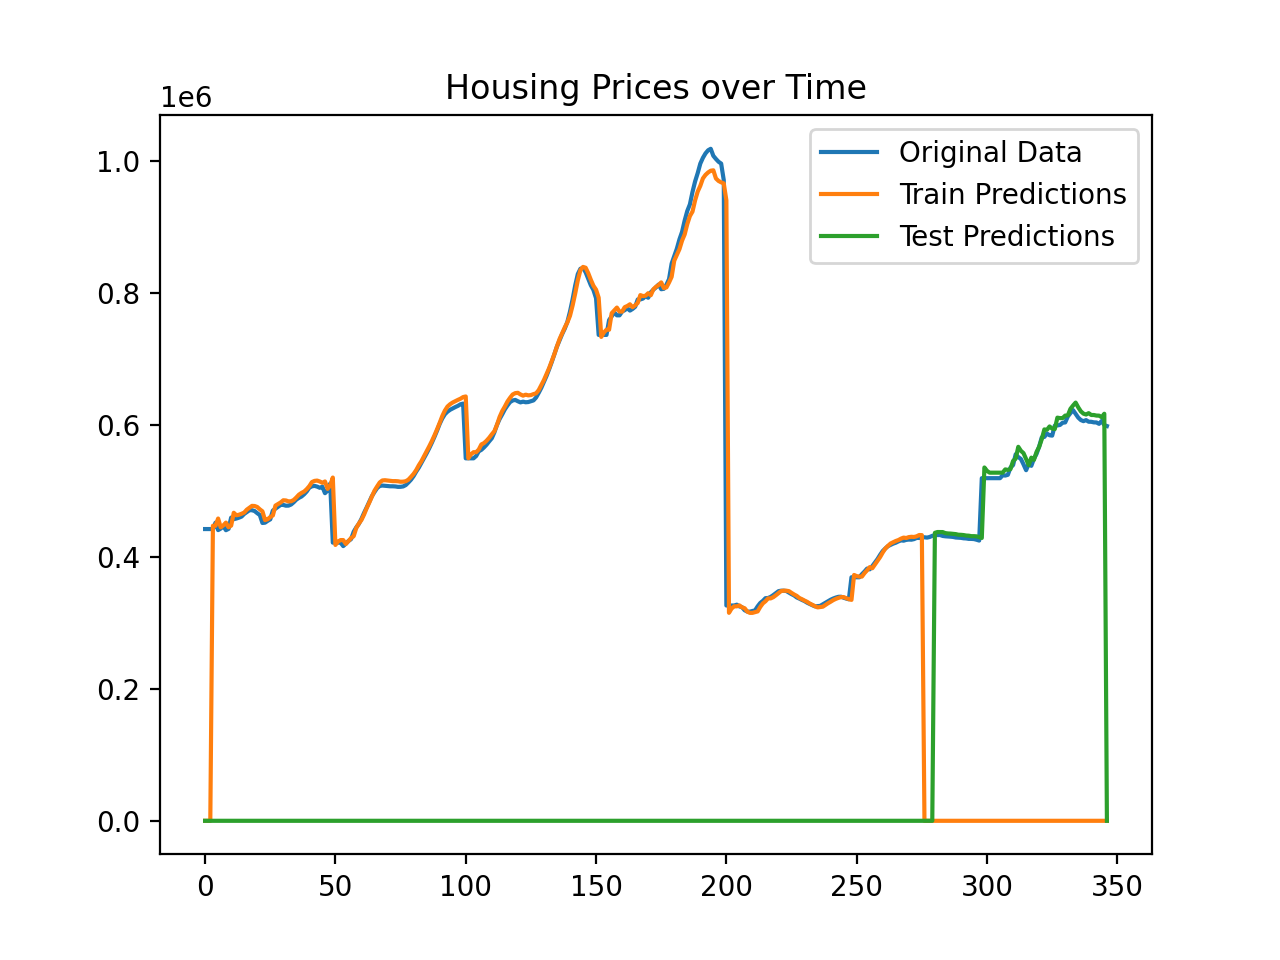

In [81]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

## Train Test Split 2
In this train/test split we will be using an 65/35 split to run two neural networks, one SimpleRNN and one LSTM model, with a lookback value of 1.

### LSTM: 1 Day Lookback

In [89]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .65)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

225 122
(223, 1) (120, 1)
(223, 1, 1) (120, 1, 1)


In [90]:
# LSTM Neural Network
model = Sequential()
model.add(LSTM(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


223/223 - 2s - 8ms/step - loss: 0.1464 - mean_squared_error: 0.1464
Epoch 2/100
223/223 - 0s - 1ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 3/100
223/223 - 0s - 1ms/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 4/100
223/223 - 0s - 1ms/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 5/100
223/223 - 0s - 1ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 6/100
223/223 - 0s - 1ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 7/100
223/223 - 0s - 1ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 8/100
223/223 - 0s - 1ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 9/100
223/223 - 0s - 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 10/100
223/223 - 0s - 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 11/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 12/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 13/100
223/223 - 0s - 1ms/step - loss: 0.00

In [91]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 44657.51676543327
Test RMSE: 13787.761217098301


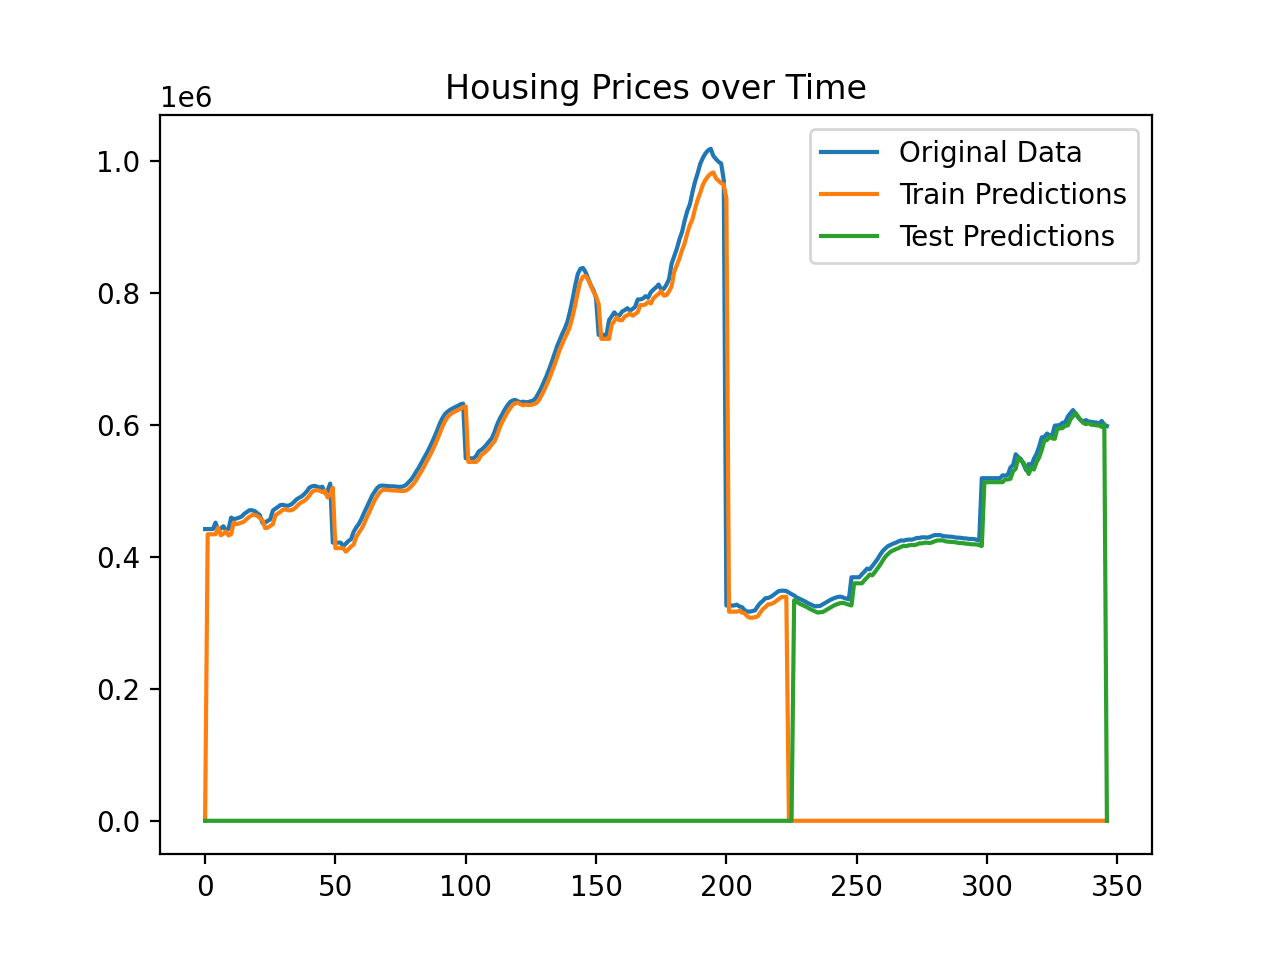

In [92]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### Simple RNN: 1 Day Lookback

In [93]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .65)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

225 122
(223, 1) (120, 1)
(223, 1, 1) (120, 1, 1)


In [94]:
# Simple RNN Network
model = Sequential()
model.add(SimpleRNN(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


223/223 - 1s - 7ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 2/100
223/223 - 0s - 1ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/100
223/223 - 0s - 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 4/100
223/223 - 0s - 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 6/100
223/223 - 0s - 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 7/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 8/100
223/223 - 0s - 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 9/100
223/223 - 0s - 1ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 10/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/100
223/223 - 0s - 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 12/100
223/223 - 0s - 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 13/100
223/223 - 0s - 1ms/step - loss: 0.00

In [95]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 45479.96280318314
Test RMSE: 15197.307117535087


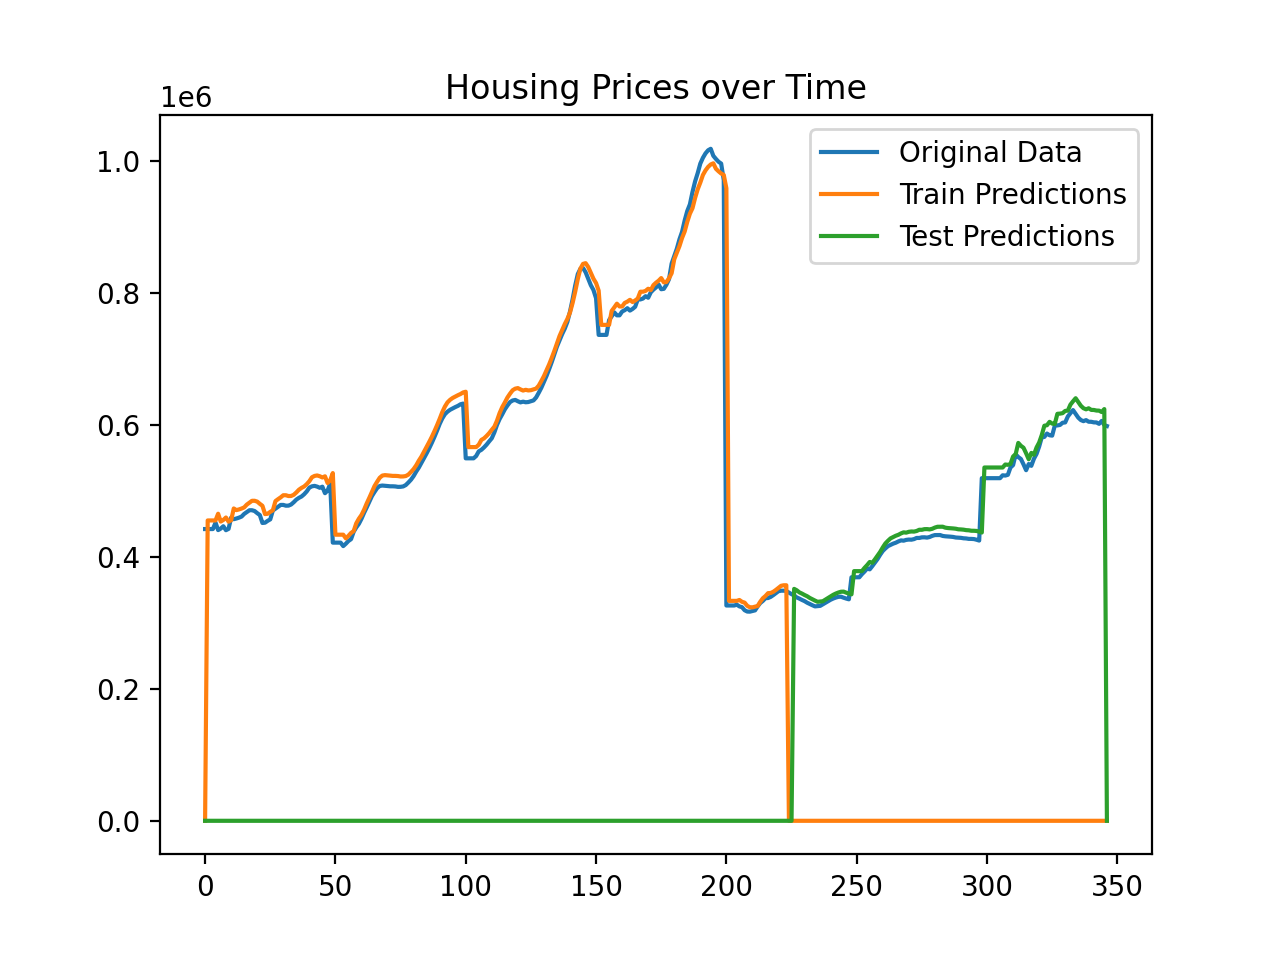

In [96]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

## Train Test Split 3
In this train/test split we will be using an 50/50 split to run two neural networks, one SimpleRNN and one LSTM model, with a lookback value of 1.

### LSTM: 1 Day Lookback

In [100]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .5)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

173 174
(171, 1) (172, 1)
(171, 1, 1) (172, 1, 1)


In [101]:
# LSTM Neural Network
model = Sequential()
model.add(LSTM(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


171/171 - 2s - 10ms/step - loss: 0.0700 - mean_squared_error: 0.0700
Epoch 2/100
171/171 - 0s - 1ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 3/100
171/171 - 0s - 1ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 4/100
171/171 - 0s - 1ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 5/100
171/171 - 0s - 1ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 6/100
171/171 - 0s - 1ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 7/100
171/171 - 0s - 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 8/100
171/171 - 0s - 1ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 9/100
171/171 - 0s - 1ms/step - loss: 4.7058e-04 - mean_squared_error: 4.7058e-04
Epoch 10/100
171/171 - 0s - 1ms/step - loss: 3.6424e-04 - mean_squared_error: 3.6424e-04
Epoch 11/100
171/171 - 0s - 1ms/step - loss: 3.4297e-04 - mean_squared_error: 3.4297e-04
Epoch 12/100
171/171 - 0s - 1ms/step - loss: 3.5518e-04 - mean_squared_error: 3.5518e-04
Epoch 13/100
171

In [102]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 13547.846912509256
Test RMSE: 50854.4826926968


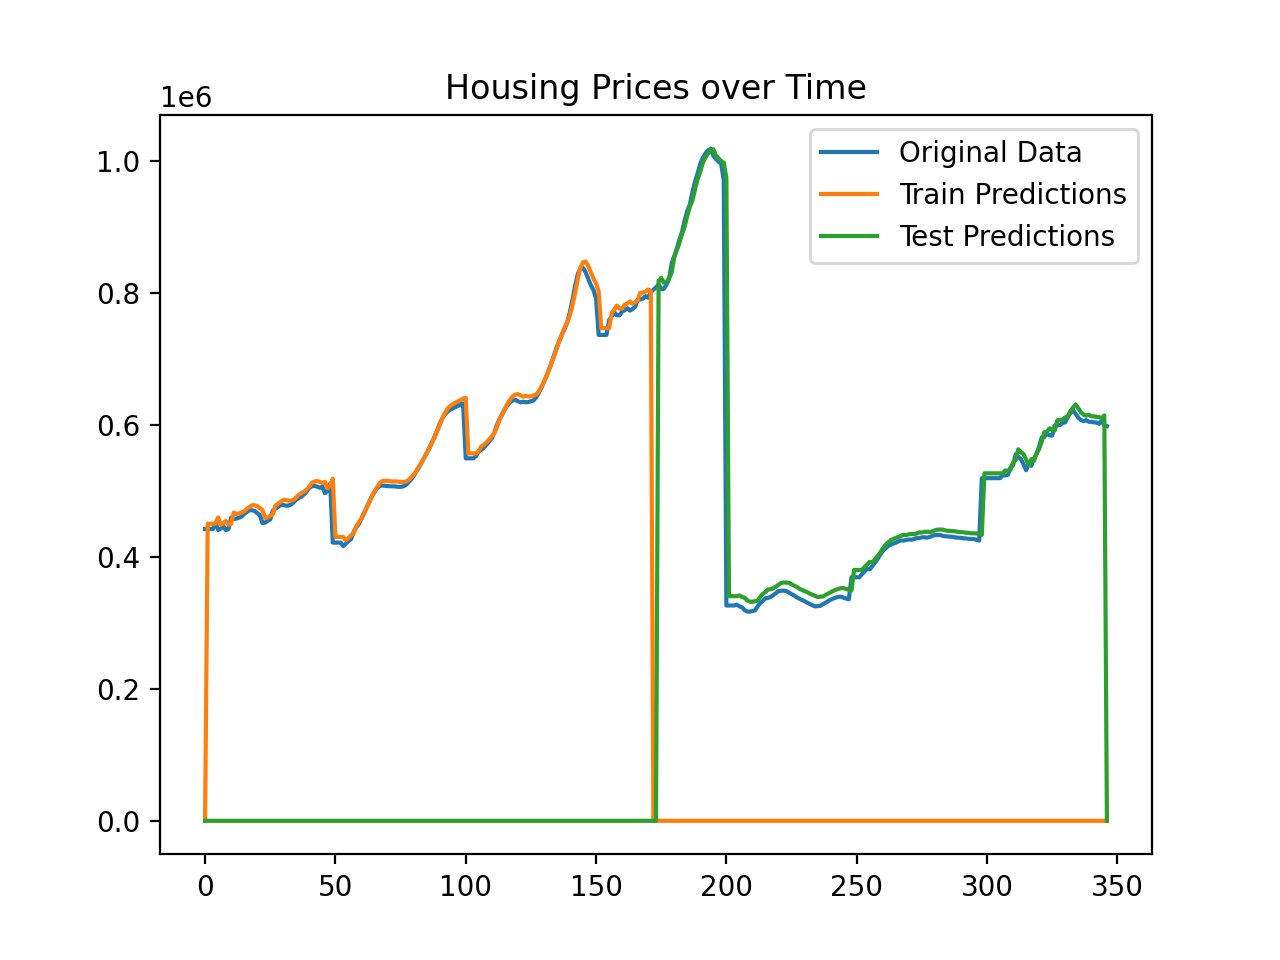

In [103]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()

### Simple RNN: 1 Day Lookback

In [108]:
data_path = "/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/PropertyData/ma_lga_12345.csv"
data = pd.read_csv(data_path)

le = preprocessing.LabelEncoder()
data["type"] = le.fit_transform(data["type"])
data = data.drop(["saledate"], axis = 1)
data = data[["MA"]]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train test split of 80/20
train_size = int(len(data) * .5)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:]
print(len(train), len(test))

# Reshape dataset to X = t and y = t+1
# Look back 1 day
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
print(X_train.shape, X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

173 174
(171, 1) (172, 1)
(171, 1, 1) (172, 1, 1)


In [109]:
# Simple RNN Network
model = Sequential()
model.add(SimpleRNN(8, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100


/Users/ben/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


171/171 - 1s - 5ms/step - loss: 0.0701 - mean_squared_error: 0.0701
Epoch 2/100
171/171 - 0s - 707us/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 3/100
171/171 - 0s - 706us/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 4/100
171/171 - 0s - 684us/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 5/100
171/171 - 0s - 688us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 6/100
171/171 - 0s - 691us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 7/100
171/171 - 0s - 681us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 8/100
171/171 - 0s - 681us/step - loss: 6.0346e-04 - mean_squared_error: 6.0346e-04
Epoch 9/100
171/171 - 0s - 717us/step - loss: 4.0382e-04 - mean_squared_error: 4.0382e-04
Epoch 10/100
171/171 - 0s - 675us/step - loss: 3.4055e-04 - mean_squared_error: 3.4055e-04
Epoch 11/100
171/171 - 0s - 655us/step - loss: 3.3185e-04 - mean_squared_error: 3.3185e-04
Epoch 12/100
171/171 - 0s - 699us/step - loss: 3.1598e-04 - mean_squared_error

In [110]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
# Unscale predictions
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], y_pred_train[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], y_pred_test[:, 0]))
print(f"Train RMSE: {train_score}")
print(f"Test RMSE: {test_score}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
Train RMSE: 12128.664949137257
Test RMSE: 49270.36598661983


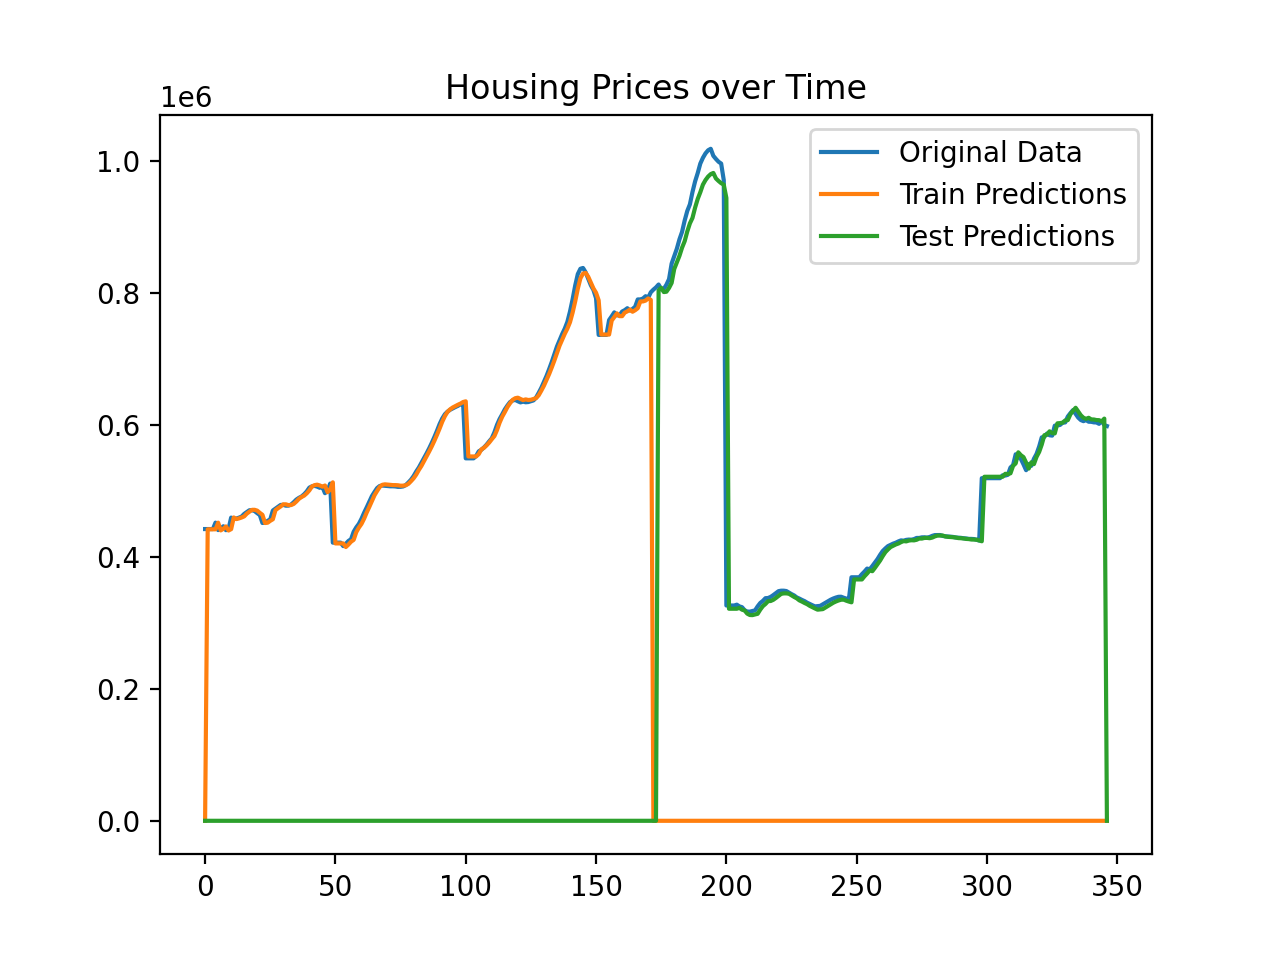

In [111]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = 0
train_predict_plot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = 0
test_predict_plot[len(y_pred_train)+(look_back*2)+1:len(data)-1, :] = y_pred_test

plt.plot(scaler.inverse_transform(data.copy()), label="Original Data")
plt.plot(train_predict_plot, label="Train Predictions")
plt.plot(test_predict_plot, label="Test Predictions")
plt.legend()
plt.title("Housing Prices over Time")
plt.show()